# Example use case: Zero-age stellar luminosity function

In this notebook we compute the luminosity function of the zero-age main-sequence by running a population of single stars using binary_c. 

We start by loading in some standard Python modules and the binary_c module.


In [1]:
import os
import math
import matplotlib.pyplot as plt

from binarycpython.utils.functions import temp_dir
from binarycpython.utils.grid import Population

TMP_DIR = temp_dir("notebooks", "notebook_luminosity")

# help(Population) # Uncomment this line to see the public functions of this object

## Setting up the Population object
To set up and configure the population object we need to make a new instance of the `Population` object and configure it with the `.set()` function.

In our case, we only need to set the maximum evolution time to something short, because we care only about zero-age main sequence stars which have, by definition, age zero.

In [2]:
# Create population object
population = Population()

# If you want verbosity, set this before other things
population.set(verbosity=1)

# Setting values can be done via .set(<parameter_name>=<value>)
# Values that are known to be binary_c_parameters are loaded into bse_options.
# Those that are present in the default grid_options are set in grid_options
# All other values that you set are put in a custom_options dict
population.set(
    # binary_c physics options
    max_evolution_time=0.1,  # maximum stellar evolution time in Myr
    tmp_dir=TMP_DIR,
)

# We can access the options through 
print("verbosity is", population.grid_options['verbosity'])

adding: tmp_dir=/tmp/binary_c_python-david/notebooks/notebook_luminosity to grid_options
verbosity is 1


## Adding grid variables
The main purpose of the Population object is to handle the population synthesis side of running a set of stars. The main method to do this with binarycpython, as is the case with Perl binarygrid, is to use grid variables. These are loops over a predefined range of values, where a probability will be assigned to the systems based on the chosen probability distributions.

Usually we use either 1 mass grid variable, or a trio of mass, mass ratio and period (other notebooks cover these examples). We can, however, also add grid sampling for e.g. eccentricity, metallicity or other parameters. 

To add a grid variable to the population object we use `population.add_grid_variable`

In [3]:
# help(population.add_grid_variable)

First let us set up some global variables that will be useful throughout.

* The resolution is the number of stars we simulate in our model population.
* The massrange is a list of the min and max masses
* The total_probability is the theoretical integral of a probability density function, i.e. 1.0.
* The binwidth sets the resolution of the final distribution. If set to 0.5, the bins in log*L* are 0.5dex wide.

In [4]:
# Set resolution and mass range that we simulate
resolution = {"M_1": 40} # start with resolution = 10, and increase later if you want "more accurate" data
massrange = (0.07, 100.0) # we work with stars of mass 0.07 to 100 Msun
total_probability = 1.0 # theoretical integral of the mass probability density function over all masses    

# distribution binwidths : 
# (log10) luminosity distribution
binwidth = { 'luminosity' : 0.5 }

The next cell contains an example of adding the mass grid variable, sampling the phase space in linear mass *M*_1.

In [5]:
# Mass
population = Population()
population.set(
    tmp_dir=TMP_DIR,
)
population.add_grid_variable(
    name="M_1",
    longname="Primary mass",
    valuerange=massrange,
    samplerfunc="self.const_linear({min}, {max}, {res})".format(
        min=massrange[0],
        max=massrange[1],
        res=resolution["M_1"]
    ),
    probdist="{probtot}/({max} - {min})".format(
        probtot=total_probability,
        min=massrange[0],
        max=massrange[1]
    ), # dprob/dm1 : all stars are equally likely so this is 1.0 / (Mmax - Mmin)
    dphasevol="dM_1",
    parameter_name="M_1",
    condition="",  # Impose a condition on this grid variable. Mostly for a check for yourself
)

## Setting logging and handling the output
By default, binary_c will not output anything (except for 'SINGLE STAR LIFETIME'). It is up to us to determine what will be printed. We can either do that by hardcoding the print statements into `binary_c` (see documentation binary_c) or we can use the custom logging functionality of binarycpython (see notebook `notebook_custom_logging.ipynb`), which is faster to set up and requires no recompilation of binary_c, but is somewhat more limited in its functionality. For our current purposes, it works perfectly well.

After configuring what will be printed, we need to make a function to parse the output. This can be done by setting the parse_function parameter in the population object (see also notebook `notebook_individual_systems.ipynb`). 

In the code below we will set up both the custom logging and a parse function to handle that output.

In [6]:
# Create custom logging statement
#
# we check that the model number is zero, i.e. we're on the first timestep (stars are born on the ZAMS)
# we make sure that the stellar type is <= MAIN_SEQUENCE, i.e. the star is a main-sequence star
# we also check that the time is 0.0 (this is not strictly required, but good to show how it is done)
#
# The Printf statement does the outputting: note that the header string is ZERO_AGE_MAIN_SEQUENCE_STAR

custom_logging_statement = """
if(stardata->model.model_number == 0 &&
   stardata->star[0].stellar_type <= MAIN_SEQUENCE &&
   stardata->model.time == 0)
{
   /* Note that we use Printf - with a capital P! */
   Printf("ZERO_AGE_MAIN_SEQUENCE_STAR %30.12e %g %g %g %g\\n",
          stardata->model.time, // 1
          stardata->common.zero_age.mass[0], // 2
          stardata->star[0].mass, // 3
          stardata->star[0].luminosity, // 4
          stardata->model.probability // 5
      );
};
"""

population.set(
    C_logging_code=custom_logging_statement
)


The parse function must now catch lines that start with "ZERO_AGE_MAIN_SEQUENCE_STAR" and process the associated data.

In [7]:
# import the bin_data function so we can construct finite-resolution probability distributions
# import the datalinedict to make a dictionary from each line of data from binary_c
from binarycpython.utils.functions import bin_data,datalinedict

def parse_function(self, output):
    """
    Example parse function
    """
    
    # list of the data items
    parameters = ["header", "time", "zams_mass", "mass", "luminosity", "probability"]
    
    # Loop over the output.
    for line in output.splitlines():
        # obtain the line of data in dictionary form 
        linedata = datalinedict(line,parameters)

        # Check the header and act accordingly
        if linedata['header'] == "ZERO_AGE_MAIN_SEQUENCE_STAR":

            # bin the log10(luminosity) to the nearest 0.1dex
            binned_log_luminosity = bin_data(math.log10(linedata['luminosity']),
                                             binwidth['luminosity'])

            # append the data to the results_dictionary 
            self.grid_results['luminosity distribution'][binned_log_luminosity] += linedata['probability'] 
    
    # verbose reporting
    #print("parse out results_dictionary=",self.grid_results)
    
# Add the parsing function
population.set(
    parse_function=parse_function,
)

## Evolving the grid
Now that we configured all the main parts of the population object, we can actually run the population! Doing this is straightforward: `population.evolve()`

This will start up the processing of all the systems. We can control how many cores are used by settings `num_cores`. By setting the `verbosity` of the population object to a higher value we can get a lot of verbose information about the run, but for now we will set it to 0.

There are many grid_options that can lead to different behaviour of the evolution of the grid. Please do have a look at those: [grid options docs](https://ri0005.pages.surrey.ac.uk/binary_c-python/grid_options_descriptions.html), and try  

In [8]:
# set number of threads
population.set(
    # verbose output is not required    
    verbosity=0,
    # set number of threads (i.e. number of CPU cores we use)
    num_cores=2,
)

# Evolve the population - this is the slow, number-crunching step
analytics = population.evolve()  

# Show the results (debugging)
# print (population.grid_results)

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 39 stars with a total probability of 1
**************************
*         Dry run        *
*  Total starcount is 39 *
* Total probability is 1 *
**************************

Do join of subprocesses ...
Joined subprocesses.
**********************************************************
*  Population-6afcef10590f48f3b089a6e5bffc70c4 finished! *
*               The total probability is 1.              *
*  It took a total of 1.11s to run 39 systems on 2 cores *
*                   = 2.22s of CPU time.                 *
*              Maximum memory use 335.164 MB             *
**********************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


After the run is complete, some technical report on the run is returned. I stored that in `analytics`. As we can see below, this dictionary is like a status report of the evolution. Useful for e.g. debugging.

In [9]:
print(analytics)

{'population_id': '6afcef10590f48f3b089a6e5bffc70c4', 'evolution_type': 'grid', 'failed_count': 0, 'failed_prob': 0, 'failed_systems_error_codes': [], 'errors_exceeded': False, 'errors_found': False, 'total_probability': 1.0, 'total_count': 39, 'start_timestamp': 1655551739.2635226, 'end_timestamp': 1655551740.371832, 'time_elapsed': 1.108309268951416, 'total_mass_run': 1951.3650000000002, 'total_probability_weighted_mass_run': 50.035, 'zero_prob_stars_skipped': 0}


[None]

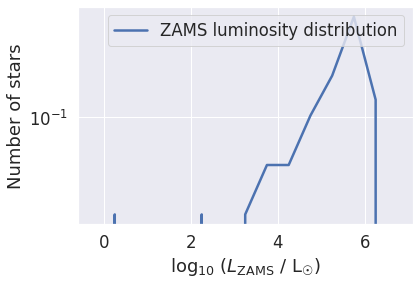

In [10]:
# make a plot of the luminosity distribution using Seaborn and Pandas
import seaborn as sns
import pandas as pd
from binarycpython.utils.functions import pad_output_distribution

# set up seaborn for use in the notebook
sns.set(rc={'figure.figsize':(20,10)})
sns.set_context("notebook",
                font_scale=1.5,
                rc={"lines.linewidth":2.5})
                    

# this saves a lot of typing! 
ldist = population.grid_results['luminosity distribution']

# pad the distribution with zeros where data is missing
pad_output_distribution(ldist,
                        binwidth['luminosity'])

# make pandas dataframe from our sorted dictionary of data
plot_data = pd.DataFrame.from_dict({'ZAMS luminosity distribution' : ldist})

# make the plot
p = sns.lineplot(data=plot_data)
p.set_xlabel("$\log_{10}$ ($L_\mathrm{ZAMS}$ / L$_{☉}$)")
p.set_ylabel("Number of stars")
p.set(yscale="log")

Does this look like a reasonable stellar luminosity function to you? The implication is that the most likely stellar luminosity is 10<sup>5.8</sup> L<sub>☉</sub>! Clearly, this is not very realistic... let's see what went wrong.

## ZAMS Luminosity distribution with the initial mass function

In the previous example, all the stars in our grid had an equal weighting. This is very unlikely to be true in reality: indeed, we know that low mass stars are far more likely than high mass stars.  So we now include an initial mass function as a three-part power law based on Kroupa (2001). Kroupa's distribution is a three-part power law: we have a function that does this for us (it's very common to use power laws in astrophysics).


In [11]:
# Update the probability distribution to use the three-part power law IMF 
population.update_grid_variable(
    name="M_1",
    probdist="self.three_part_powerlaw(M_1, 0.1, 0.5, 1.0, 150, -1.3, -2.3, -2.3)",
)

In [12]:
# Clean and re-evolve the population 
population.clean()
analytics = population.evolve()  

# Show the results (debugging)
# print (population.grid_results)

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 39 stars with a total probability of 0.211729
**********************************
*             Dry run            *
*      Total starcount is 39     *
*  Total probability is 0.211729 *
**********************************

Do join of subprocesses ...
Joined subprocesses.
**********************************************************
*  Population-452bcf6eb93e4e2493019ec93ee250df finished! *
*           The total probability is 0.211729.           *
*  It took a total of 1.27s to run 39 systems on 2 cores *
*                   = 2.54s of CPU time.                 *
*              Maximum memory use 468.883 MB             *
**********************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


[None]

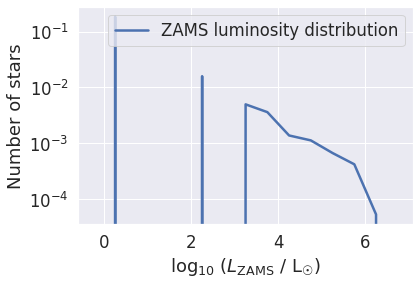

In [13]:
# plot luminosity distribution
ldist = population.grid_results['luminosity distribution']

# pad the distribution with zeros where data is missing
pad_output_distribution(ldist,
                        binwidth['luminosity'])

# make pandas dataframe from our sorted dictionary of data
plot_data = pd.DataFrame.from_dict({'ZAMS luminosity distribution' : ldist})

# make the plot
p = sns.lineplot(data=plot_data)
p.set_xlabel("$\log_{10}$ ($L_\mathrm{ZAMS}$ / L$_{☉}$)")
p.set_ylabel("Number of stars")
p.set(yscale="log")

This distribution is peaked at low luminosity, as one expects from observations, but the resolution is clearly not great because it's not smooth - it's spiky! 

If you noticed above, the total probability of the grid was about 0.2. Given that the total probability of a probability distribution function should be 1.0, this shows that our sampling is (very) poor. 

We could simply increase the resolution to compensate, but this is very CPU intensive and a complete waste of time and resources. Instead, let's try sampling the masses of the stars in a smarter way.

## A better-sampled grid

The IMF has many more low-mass stars than high-mass stars. So, instead of sampling M1 linearly, we can sample it in log space. 

To do this we first rename the mass grid variable so that it is clear we are working in (natural) logarithmic phase space.

In [14]:
# Rename the old variable (M_1) because we want it to be called lnM_1 now
population.rename_grid_variable("M_1", "lnM_1")

Next, we change the spacing function so that it works in the log space. We also adapt the probability calculation so that it calculates dprob/dlnM = M * dprob/dM. Finally, we set the precode to compute M_1 because binary_c requires the actual mass, not the logarithm of the mass.

In [15]:
# update the sampling, note that the IMF is dprob/dM1, and the phase 
# space is now sampled in lnM1, so we multiply by M_1 to 
# because  M * dprob/dM = dprob/dlnM
population.update_grid_variable(
    name="lnM_1",
    samplerfunc="self.const_linear(math.log({min}), math.log({max}), {res})".format(min = massrange[0], max = massrange[1], res = resolution["M_1"]),
    probdist="self.three_part_powerlaw(M_1, 0.1, 0.5, 1.0, 150, -1.3, -2.3, -2.3)*M_1",
    dphasevol="dlnM_1",
    parameter_name="M_1",
    precode="M_1=math.exp(lnM_1)",
)
# print(population.grid_options["_grid_variables"]) # debugging

In [16]:
# Clean and re-evolve the population 
population.clean()
analytics = population.evolve()  

# Show the results (debugging)
# print (population.grid_results)

Do dry run? True
Doing dry run to calculate total starcount and probability
Grid has handled 39 stars with a total probability of 0.991317
**********************************
*             Dry run            *
*      Total starcount is 39     *
*  Total probability is 0.991317 *
**********************************

Do join of subprocesses ...
Joined subprocesses.
**********************************************************
*  Population-ec5d853278c743a3acdb8ab290f641df finished! *
*           The total probability is 0.991317.           *
*  It took a total of 1.01s to run 39 systems on 2 cores *
*                   = 2.02s of CPU time.                 *
*              Maximum memory use 475.789 MB             *
**********************************************************

No failed systems were found in this run.
Do analytics
Added analytics to metadata


You should see that the total probability is very close to 1.0, as you would expect for a well-sampled grid. The total will never be exactly 1.0, but that is because we are running a simulation, not a perfect copy of reality.

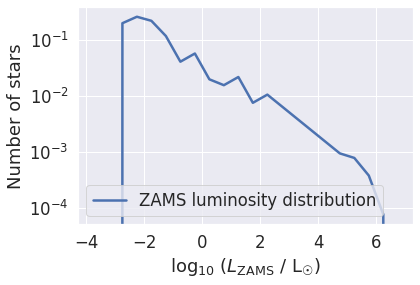

In [17]:
# plot luminosity distribution
ldist = population.grid_results['luminosity distribution']

# pad the distribution with zeros where data is missing
pad_output_distribution(ldist,
                        binwidth['luminosity'])

# make pandas dataframe from our sorted dictionary of data
plot_data = pd.DataFrame.from_dict({'ZAMS luminosity distribution' : ldist})

# make the plot
p = sns.lineplot(data=plot_data)
p.set_xlabel("$\log_{10}$ ($L_\mathrm{ZAMS}$ / L$_{☉}$)")
p.set_ylabel("Number of stars")
p.set(yscale="log")
plt.show()

Most stars are low mass red dwarfs, with small luminosities. Without the IMF weighting, our model population would have got this completely wrong! 

As you increase the resolution, you will see this curve becomes even smoother. The wiggles in the curve are (usually) sampling artefacts because the curve should monotonically brighten above about log(*L*/L<sub>☉</sub>)=-2. 
 
Remember you can play with the binwidth too. If you want a very accurate distribution you need a narrow binwidth, but then you'll also need high resolution (lots of stars) so lots of CPU time, hence cost, CO<sub>2</sub>, etc.

Things to try:

* Change the resolution to make the distributions smoother: what about error bars, how would you do that?
* Different initial distributions: the Kroupa distribution isn't the only one out there
* Change the metallicity and mass ranges
* What about a non-constant star formation rate? This is more of a challenge!
* What about evolved stars? Here we consider only the *zero-age* main sequnece. What about other main-sequence stars? What about stars in later phases of stellar evolution?
* Binary stars! (see notebook_luminosity_function_binaries.ipynb)